## Helper functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

def get_filenames(path):
  bpm_files = []
  speed_files = []
  for file in os.listdir(path):
    if file[0:3]=='bpm':
      bpm_files.append(file)
    elif file[0:5] == 'speed':
      speed_files.append(file)
    # logging.debug('Critic training done in epoch {}'.format(epoch))
  assert len(bpm_files)==len(speed_files)
  bpm_files.sort()
  speed_files.sort()
  print(str(len(bpm_files))+' bpm files and '+ str(len(speed_files))+ ' speed files')
  return bpm_files, speed_files

def access_data(result):
  count1 = np.isinf(result['speed']).values.sum()
  count2 = np.isnan(result['speed']).values.sum()
  count3 = np.isinf(result['bpm']).values.sum()
  count4 = np.isnan(result['bpm']).values.sum()
  stat_null = [count1, count2, count3, count4]
  print("It contains " + str( stat_null[0]) + " infinite values in speed")
  print("It contains " + str(stat_null[1]) + " null values in speed")
  print("It contains " + str(stat_null[2]) + " infinite values in bpm")
  print("It contains " + str(stat_null[3]) + " null values in bpm")
  # print(len(result))

def merger(X, bigdata = pd.DataFrame({}) ):
  for x in X:
    bigdata = pd.concat([ bigdata,  x[['bpm','speed','id']]], ignore_index=True, sort=False)
  return bigdata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_dataset(): 
  path = '/content/drive/MyDrive/SinAI/DATASET_corse'
  bpm_files, speed_files = get_filenames(path)

  #read and store bpm and speed values and startTimes for each session
  sessions = pd.DataFrame({})
  sess_panda =[]
  stat_null = []
  total = 0
  # splitter = int(len(sessions)*0.8)
  for session in range(0, len(bpm_files)):
    
    b_path = path + '/'+bpm_files[session]
    s_path = path + '/'+speed_files[session]
    #retrieving only useful columns
    table_b = pd.read_csv(b_path,usecols= ['value','startTime','data'], dtype = {'value': float})
    table_s = pd.read_csv(s_path,usecols= ['value','startTime','delta_T','data'], dtype = {'value': float})

    # combining timestamp with data yyyy/mm/dd and removing data
    table_b['time'] = pd.to_datetime(table_b['data'] + ' '+ table_b['startTime'] )
    table_b.drop(columns=['data','startTime'], inplace=True, axis=1)
    table_b = table_b.set_index('time')
    table_b.columns.values[0] = "bpm"

    table_s['startTime'] = pd.to_datetime(table_s['data'] + ' '+ table_s['startTime'] )
    table_s.drop(columns='data', inplace=True, axis=1)
    table_s.columns.values[2] = "speed"

    # #linspace-ing in sec deltaT into array offset and copy all other columns,
    # # transform offset into timestamp, add to startTime and store as time
    # # set time as index and drop useless columns
    table_s['offset'] = table_s['delta_T'].apply(lambda x: list(range(x)))
    table_s = table_s.explode('offset')
    table_s['offset'] = table_s['offset'].apply(lambda x: pd.Timedelta(x, unit='S'))
    table_s['time'] = table_s['startTime']+ table_s['offset']
    table_s = table_s.set_index('time')

    table_s.drop(columns=['offset','startTime','delta_T'], inplace=True, axis=1)
    table_s.rename(columns={"value": "speed"})

    # #combined tables 
    result = pd.concat( [table_s, table_b],axis=1)
    result.reset_index(level=0, inplace=True)
    result['id'] = result.index

    # # result['ts'] = result.time.values.astype(np.int64) // 10 ** 9
    # # result = result.set_index('ts')
    result.drop(columns='time', inplace=True, axis=1)
    
    total += len(result)
    sess_panda.append(result)
  return sess_panda


In [4]:
def preprocess(x):
  df = merger(x)
  max_speed = df.loc[df['speed'] != np.inf, 'speed'].max()
  if max_speed < 10*df["speed"].median():
    max_speed = 10*df["speed"].median()
  df['speed'] = df['speed'].replace({np.inf: max_speed, -np.inf: df[np.isfinite(df)].min().min()})
  df = df.interpolate(method='linear', order = 2)
  df = df.fillna(method="bfill")
  df = df.fillna(method="ffill")
  return df
def score_scaler(score):
  scaler_score = MinMaxScaler()
  return np.squeeze(scaler_score.fit_transform(score.reshape(-1, 1)).reshape(1, -1))

## Dataset preparation


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [6]:
train_path        = '/content/drive/MyDrive/SinAI/train_loader.pt'
test_path         = '/content/drive/MyDrive/SinAI/test_loader.pt'
train_data_path   = '/content/drive/MyDrive/SinAI/train.csv'
test_data_path    = '/content/drive/MyDrive/SinAI/test.csv'
scores_path       = '/content/drive/MyDrive/SinAI/test_scores.csv'

In [7]:
if not os.path.exists(train_data_path) or not os.path.exists(test_data_path) :
  X_train, X_test = train_test_split(load_dataset(),test_size=0.2,random_state=27)
  train_data = preprocess(X_train)
  test_data  = preprocess(X_test)
  train_data.to_csv(train_data_path, index=False)
  test_data.to_csv(test_data_path, index=False)
else:
  train_data = pd.read_csv(train_data_path)
  test_data  = pd.read_csv(test_data_path)

In [16]:
scaler_standard = StandardScaler().fit(train_data)
train_scaled_std_2 = pd.DataFrame(scaler_standard.transform(train_data), columns=train_data.columns).drop('id', axis=1)
test_scaled_std_2  = pd.DataFrame(scaler_standard.transform(test_data), columns=test_data.columns).drop('id', axis=1)
if not os.path.exists(scores_path) :
  test_with_scores= test_data.copy()
else:
  test_with_scores = pd.read_csv(scores_path)
methods = ['knn', 'ocsvm', 'kde','gan']
thresholds = {}

In [9]:
start_index = test_with_scores.index[test_with_scores['id']==0].tolist()


##Plotting

https://matplotlib.org/stable/gallery/color/named_colors.html
https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [10]:
def anomaly_classify(score, threshold, test, plot = False):
  outlier_index = np.where(score> threshold)
  outlier_values = test.iloc[outlier_index]
  clean_data = test.drop(outlier_index[0])
  if plot :
    plot_all(clean_data, outlier_values, speed_bpm = True, speed_bpm_time = True, all = True )
  return outlier_index

In [11]:
def plot_all(df, outlier_values, speed_bpm = False, speed_bpm_time = False, all = True, with_limits = False ):
  plt.figure()
  if speed_bpm:
      # plot data 2d: speed and bpm
    plt.scatter( df["speed"], df["bpm"], color = "b",label='all')
    plt.scatter(outlier_values["speed"], outlier_values["bpm"], color = "r", label = 'outliers')
    if with_limits:
      plt.xlim(-5, 30)
      plt.ylim(0, 200)
    plt.xlabel('speed')
    plt.ylabel('bpm')
    plt.title("speed vs bpm plot")
    plt.legend()
    plt.show()
  if speed_bpm_time:
      # # plot data 2d spped bpm vs time
    plt.scatter(df["id"], df["speed"], color = "b",label = 'speed')
    plt.scatter(df["id"], df["bpm"], color = "g", label = 'bpm')
    plt.scatter(outlier_values["id"], outlier_values["speed"], color = "r", label ='outlier speed')
    plt.scatter(outlier_values["id"], outlier_values["bpm"], color = "m", label = 'outlier bpm')
    if with_limits:
      # plt.xlim(-5, 30)
      plt.ylim(-10, 200)
    plt.xlabel('timestamp')
    plt.ylabel('bpm and speed')
    plt.title("speed, bpm vs time plot")
    plt.legend()
    plt.show()
  if all:
    #plot 3d speed vs bpm vs time\
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter( df["id"], df["speed"],df["bpm"], color = "b", label = 'normal')#, marker='o')
    ax.scatter( outlier_values["id"], outlier_values["speed"], outlier_values["bpm"], color = "r", marker='o', label ='outliers')
    ax.set_xlabel('id')
    ax.set_ylabel('speed')
    ax.set_zlabel('bpm')
    plt.legend()
    plt.show()


In [12]:
def plot_anomaly_score_bar(scores, test,with_limits = False, title=''):
  plt.figure()
  # if scores.max()>1 or scores.min()< 1:
  #   scores = score_scaler(scores)
  plt.scatter(test["speed"],test["bpm"],marker="x",c=scores,cmap='summer');
  plt.xlabel('speed')
  plt.ylabel('bpm')
  if with_limits:
      plt.xlim(-5, 30)
      plt.ylim(0, 200)
  plt.title("Anomaly score by "+title)
  plt.colorbar();

In [13]:
def plot_test_runs(method, test_runs,test_with_scores, run = None ):
  vmin = test_with_scores[method].min()
  vmax = test_with_scores[method].max()
  for run in test_runs:
    plt.figure()
    plt.scatter( run['id'],run['speed'], c=run[method],cmap='summer',vmin=vmin, vmax = vmax)
    plt.colorbar();
    plt.scatter( run['id'],run['bpm'],  c=run[method], cmap='cool',  vmin=vmin, vmax = vmax)
    plt.colorbar();
    plt.xlabel('time id')
    plt.ylabel('speed(green-yellow) and bpm(blue-purple)')
    plt.show()

    plt.figure()
    plt.scatter(run['speed'], run['bpm'], c=run[method], cmap='summer' ,vmin=vmin,vmax = vmax)
    plt.xlabel('speed')
    plt.ylabel(' bpm')
    plt.colorbar();
    plt.show()

In [14]:
def plot_score_distr(scores, threshold, title=''):
  plt.figure()
  plt.plot(scores)
  plt.axhline(y = threshold, color='r', linestyle='-')
  plt.ylabel('scores')
  plt.xlabel('data points')
  plt.legend(['Scores', '99.9 percentile threshold'])
  plt.title("score distribution for "+title)
  plt.show()

# KNN

In [14]:
from sklearn.neighbors import NearestNeighbors
def nn(Xtrans, n_neighbors,with_time = False):
  x = Xtrans.copy()
  if not with_time:
    x = x.drop('id', axis=1)
  nrst_neigh = NearestNeighbors(n_neighbors = n_neighbors, algorithm = 'ball_tree')
  nrst_neigh.fit(x)
  return nrst_neigh

In [15]:
def knn_score(df, nrst_neigh):
  distances, indices = nrst_neigh.kneighbors(df) 
  dist_mean = distances.mean(axis =1)
  return dist_mean

In [16]:
n_neighbors = 50

nrst_neigh_model = nn(train_scaled_std_2, n_neighbors, with_time = True)
distances, indices = nrst_neigh_model.kneighbors(train_scaled_std_2) 
dist_mean_train = distances.mean(axis = 1)
thresholds['knn']= np.percentile(dist_mean_train, 99.9)
# knn_thres = np.percentile(dist_mean_train, 99.9)
knn_test_score = knn_score(test_scaled_std_2, nrst_neigh_model)
knn_test_score_scaled = score_scaler(knn_test_score)

In [30]:
def store_score(method, scores):
  if os.path.exists(scores_path):
    test_with_scores = pd.read_csv(scores_path)
    
  test_with_scores[method] = scores
  test_with_scores.to_csv(scores_path, index=False)
  return test_with_scores


In [31]:
test_with_scores = store_score('knn', knn_test_score_scaled)

# print(test_with_scores['knn'].nlargest(10))

# knn_outlier_index = anomaly_classify(knn_test_score, knn_thres, test_data, plot= True)
# plot_anomaly_score_bar(knn_test_score, test_data, with_limits = False)
# plot_score_distr(knn_test_score, knn_thres, title= 'KNN')
# plot_test_runs('knn', test_runs,test_with_scores)


,bpm,speed,id,knn
0,93.0,5.139314,0,0.007617
1,93.0,5.139314,1,0.007617
2,93.0,5.139314,2,0.007617
3,93.0,5.139314,3,0.007617
4,93.0,5.139314,4,0.007617



# OCSVM

In [32]:
from sklearn.svm import OneClassSVM

In [33]:
modelOCSVM = OneClassSVM(kernel = 'rbf',  gamma = 0.1, nu = 0.01).fit(train_scaled_std_2)

In [34]:
OCSVM_anomaly_score = modelOCSVM.score_samples(test_scaled_std_2)

In [35]:
ocsvm_test_score_scaled = score_scaler(-OCSVM_anomaly_score)

In [37]:
test_with_scores = store_score('ocsvm', ocsvm_test_score_scaled)


,bpm,speed,id,knn,ocsvm
0,93.0,5.139314,0,0.007617,0.053807
1,93.0,5.139314,1,0.007617,0.053807
2,93.0,5.139314,2,0.007617,0.053807
3,93.0,5.139314,3,0.007617,0.053807
4,93.0,5.139314,4,0.007617,0.053807


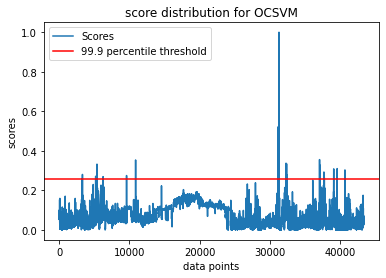

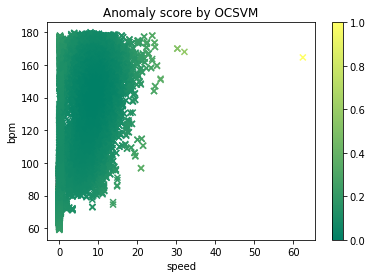

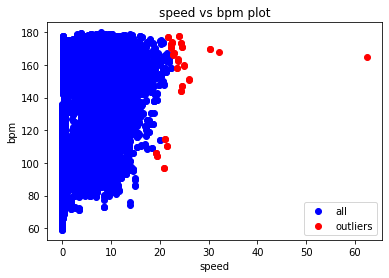

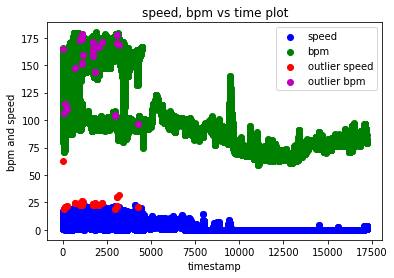

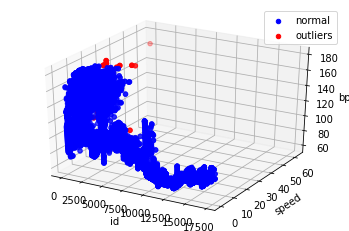

In [38]:
thresholds['ocsvm'] = np.percentile(ocsvm_test_score_scaled, 99.9)
# plot_score_distr(ocsvm_test_score_scaled, thresholds['ocsvm'], title= 'OCSVM')
# plot_anomaly_score_bar(ocsvm_test_score_scaled, test_data, title= 'OCSVM')
# OCSVM_outlier_index = anomaly_classify(ocsvm_test_score_scaled, thresholds['ocsvm'], test_data,plot= True )


#KDE

In [39]:
from sklearn.neighbors import KernelDensity

In [40]:
GDE = KernelDensity(metric ='euclidean', bandwidth=0.5, kernel = 'gaussian', atol = 0.01).fit(train_scaled_std_2)

In [41]:
KDE_anomaly_scores = GDE.score_samples(test_scaled_std_2)

In [42]:
KDE_anomaly_scores_scaled = score_scaler(-KDE_anomaly_scores)
thresholds['kde'] = np.percentile(KDE_anomaly_scores_scaled, 99.9)
test_with_scores = store_score('kde', KDE_anomaly_scores_scaled)

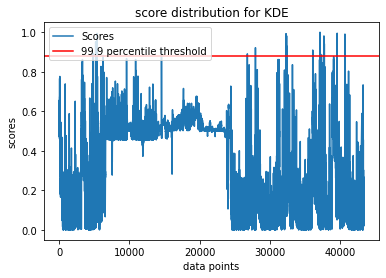

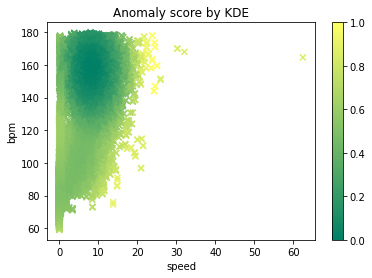

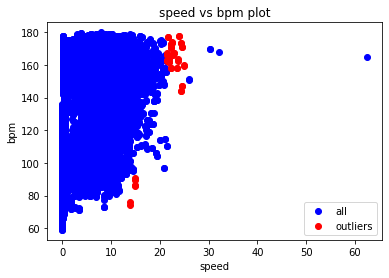

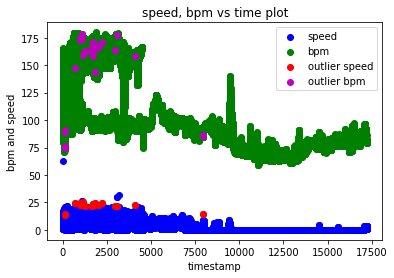

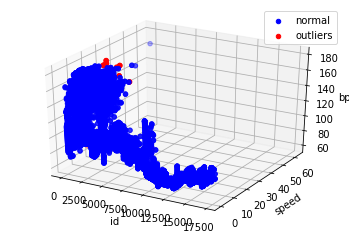

In [43]:
# plot_score_distr(KDE_anomaly_scores_scaled, thresholds['kde'], title= 'KDE')
# plot_anomaly_score_bar(KDE_anomaly_scores_scaled, test_data, title= 'KDE')
# kde_outlier_index = anomaly_classify(KDE_anomaly_scores_scaled, thresholds['kde'], test_data,plot= True )

#TagGAN dataset Prep

###TADGANs

In [20]:
import torch
import logging

import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import LSTM, Linear, Module, MSELoss
from scipy import stats

torch.manual_seed(0)


In [21]:
class Encoder(Module):
    def __init__(self, encoder_path, signal_shape=100):
        super(Encoder, self).__init__()
        self.signal_shape = signal_shape
        self.lstm = LSTM(input_size=self.signal_shape, hidden_size=20, num_layers=1, bidirectional=True)
        self.dense = Linear(in_features=40, out_features=20)
        self.encoder_path = encoder_path
        

    def forward(self, x):
        x = x.view(2, 64, self.signal_shape).float()
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return (x)

class Decoder(Module):
    def __init__(self, decoder_path, signal_shape=100):
        super(Decoder, self).__init__()
        self.signal_shape = signal_shape
        self.lstm = LSTM(input_size=20, hidden_size=64, num_layers=2, bidirectional=True)
        self.dense = Linear(in_features=128, out_features=self.signal_shape)
        self.decoder_path = decoder_path

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return (x)
class CriticX(Module):
    def __init__(self, critic_x_path, signal_shape=100):
        super(CriticX, self).__init__()
        self.signal_shape = signal_shape
        self.dense1 = Linear(in_features=self.signal_shape, out_features=20)
        self.dense2 = Linear(in_features=20, out_features=1)
        self.critic_x_path = critic_x_path

    def forward(self, x):
        x = x.view(2, 64, self.signal_shape).float()
        x = self.dense1(x)
        x = self.dense2(x)
        return (x)

class CriticZ(Module):
    def __init__(self, critic_z_path):
        super(CriticZ, self).__init__()
        self.dense1 = Linear(in_features=20, out_features=1)
        self.critic_z_path = critic_z_path

    def forward(self, x):
        x = self.dense1(x)
        return (x)

In [22]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    x = sample.view(2,64, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x) #Wasserstein Loss

    #The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through encoding x)
    z = torch.empty(2, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  #Wasserstein Loss

    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_) #Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    #Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    #Critic has to maximize Cx(Valid X) - Cx(Fake X).
    #Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss
    loss.backward()
    optim_cx.step()

    return loss
    
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    x = sample.view(2, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(2, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z) #Wasserstein Loss

    wl = critic_score_fake_z - critic_score_valid_z

    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_) #Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    loss = wl + gp_loss
    loss.backward()
    optim_cz.step()
  
    return loss

In [23]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    x = sample.view(2, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x) #Wasserstein Loss

    z = torch.empty(2, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc
    
def decoder_iteration(sample):
    optim_dec.zero_grad()

    x = sample.view(2, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(2, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z
    loss_dec.backward(retain_graph=True)
    optim_dec.step()

    return loss_dec

In [24]:
def train(n_epochs=100):
    logging.debug('Starting training')
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    for epoch in range(n_epochs):
        logging.debug('Epoch {}'.format(epoch))
        n_critics = 1
        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, [sample] in enumerate(train_loader):
                cx_loss.append(critic_x_iteration(sample))
                cz_loss.append(critic_z_iteration(sample))

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        logging.debug('Critic training done in epoch {}'.format(epoch))

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))

        torch.save(critic_x.state_dict(), critic_x.critic_x_path)
        torch.save(critic_z.state_dict(), critic_z.critic_z_path)
          


        encoder_loss = list()
        decoder_loss = list()

        for batch, [sample] in enumerate(train_loader):
            enc_loss = encoder_iteration(sample)
            dec_loss = decoder_iteration(sample)
            encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)

        
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))
        logging.debug('Encoder decoder training done in epoch {}'.format(epoch))
        logging.debug('critic x loss {:.3f} critic z loss {:.3f} \nencoder loss {:.3f} decoder loss {:.3f}\n'.format(cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))

        if epoch % 10 == 0:
          torch.save(encoder.state_dict(), encoder.encoder_path)
          torch.save(decoder.state_dict(), decoder.decoder_path)

In [25]:
def windowing(x, window_size, step_size=1):
  return x.unfold(0,window_size,step_size)

def datasetprep(df):
  torch_tensor = torch.tensor([df['bpm'].values,df['speed'].values ])
  torch_tensor = torch.transpose(torch_tensor, 0, 1)
  sliced = windowing(torch_tensor,window_size,step_size)
  return TensorDataset(sliced)

In [26]:
def dtw_reconstruction_error(x, x_):
    n, m, l = x.shape[1], x_.shape[1], x.shape[0]

    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0
            for k in range(0, l):
              cost += np.square(x[k][i-1] - x_[k][j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[n][m]

In [27]:
def detect_anomaly(anomaly_score):
    window_size = len(anomaly_score) // 3
    step_size = len(anomaly_score) // (3 * 10)

    is_anomaly = np.zeros(len(anomaly_score))

    for i in range(0, len(anomaly_score) - window_size, step_size):
        window_elts = anomaly_score[i:i+window_size]
        window_mean = np.mean(window_elts)
        window_std = np.std(window_elts)

        for j, elt in enumerate(window_elts):
            if (window_mean - 3 * window_std) < elt < (window_mean + 3 * window_std):
                is_anomaly[i + j] = 0
            else:
                is_anomaly[i + j] = 1

    return is_anomaly

In [28]:
def test(test_loader):
    reconstruction_error = list()
    critic_score = list()
    # y_true = list()

    for batch, [sample] in enumerate(test_loader):
        logging.debug('Testing done in batch {}'.format(batch))
        print('Testing done in batch {}'.format(batch))
        reconstructed_signal = decoder(encoder(sample))
        reconstructed_signal = torch.squeeze(reconstructed_signal)
        
        for i in range(0, 64):
            x_ = reconstructed_signal.select(1, i).detach().numpy()
            x = sample.select(0, i).numpy()
            # y_true.append(int(sample['anomaly'][i].detach()))
            reconstruction_error.append(dtw_reconstruction_error(x, x_))
        cxscores = torch.squeeze(critic_x(sample)).detach().numpy()
        critic_score.extend([np.mean(k) for k in zip(*cxscores)])
  
    
    reconstruction_error = stats.zscore(reconstruction_error)
    critic_score = stats.zscore(critic_score)
    anomaly_score = reconstruction_error * critic_score
    torch.save(anomaly_score, TadGAN_score_path)
    return anomaly_score
    
    # y_predict = prune_false_positive(y_predict, anomaly_score, change_threshold=0.1)
    # find_scores(y_true, y_predict)

In [29]:
def combined_scoring(anomaly_score, T, window_size_t, step_size_t):
    window_size = window_size_t // step_size_t
    step_size = 1
    scoring= []

    for i in range(0, T*step_size_t+window_size_t):
        t = i // step_size_t + 1
        start = t - window_size
        if start < 0:
          window_elts = np.concatenate((anomaly_score[start:],anomaly_score[:t]), axis=0)
        elif t>T-window_size:
          window_elts = np.concatenate((anomaly_score[start:],anomaly_score[:t-len(anomaly_score)]), axis=0)
        else:
          window_elts = anomaly_score[start:t]
        window_mean = np.mean(window_elts)
        scoring.append(window_mean)

    return scoring

##changes here

In [32]:
lr = 1e-6

signal_shape = 100
latent_space_dim = 20

window_size = 100
step_size = 5
batch_size = 64

encoder_path = '/content/drive/MyDrive/SinAI/models/encoder.pt'
decoder_path = '/content/drive/MyDrive/SinAI/models/decoder.pt'
critic_x_path = '/content/drive/MyDrive/SinAI/models/critic_x.pt'
critic_z_path = '/content/drive/MyDrive/SinAI/models/critic_z.pt'

train_path = '/content/drive/MyDrive/SinAI/train_loader.pt'
test_path = '/content/drive/MyDrive/SinAI/test_loader.pt'
TadGAN_score_path = '/content/drive/MyDrive/SinAI/models/anomaly_score_100e.pt'

encoder = Encoder(encoder_path, signal_shape)
decoder = Decoder(decoder_path, signal_shape)
critic_x = CriticX(critic_x_path, signal_shape )
critic_z =CriticZ(critic_z_path)

mse_loss = MSELoss()
optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))


In [33]:
if not os.path.exists(train_path):
  train_dataset = datasetprep(X_train)
  torch.save(train_dataset,train_path )
else:
  train_dataset = torch.load(train_path)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, pin_memory=True)
print('Number of train datapoints is {}'.format(len(train_dataset)))
print('Number of samples in train dataset {}'.format(len(train_dataset)))

if not os.path.exists(test_path):
  test_dataset = datasetprep(X_test)
  torch.save(test_dataset,test_path )
else:
  test_dataset = torch.load(test_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True,pin_memory=True)
print('Number of test datapoints is {}'.format(len(test_dataset)))
print('Number of samples in train dataset {}'.format(len(test_dataset)))

Number of train datapoints is 27483
Number of samples in train dataset 27483
Number of test datapoints is 8653
Number of samples in train dataset 8653


In [22]:
train(n_epochs=100)

In [34]:
if not os.path.exists(TadGAN_score_path):
  TadGAN_anomaly_score = test(test_loader)
  # torch.save(TadGAN_anomaly_score, TadGAN_score_path)
else:
  TadGAN_anomaly_score = torch.load(TadGAN_score_path)

In [35]:
print(str(TadGAN_anomaly_score.min())+' - ' + str(TadGAN_anomaly_score.max()))
scaled_tadGANS_anomaly_score = score_scaler(TadGAN_anomaly_score)
print(str(scaled_tadGANS_anomaly_score.min())+' - ' + str(scaled_tadGANS_anomaly_score.max()))

-1.5170037800054423 - 2.799611877833783
0.0 - 1.0


In [4]:
scores_pointwise = combined_scoring(TadGAN_anomaly_score, len(test_loader)*batch_size, window_size, step_size)

NameError: ignored

In [3]:
# take only tested data points (some dropped while )
test_data_cut = test_data[0:len(scores_pointwise)].copy()
test_data_cut['gan'] = scores_pointwise
print(test_data_cut.head(5))

test_runs_cut = []
for i in range(1, len(start_index)):
  test_runs_cut.append(test_data_cut[start_index[i-1]:start_index[i]])
test_runs_cut.append(test_data_cut[start_index[-1]:])


NameError: ignored

In [38]:
thresholds['gan'] = np.percentile(scores_pointwise, 99)

Text(0, 0.5, 'speed(green-yellow) and bpm(blue-purple)')

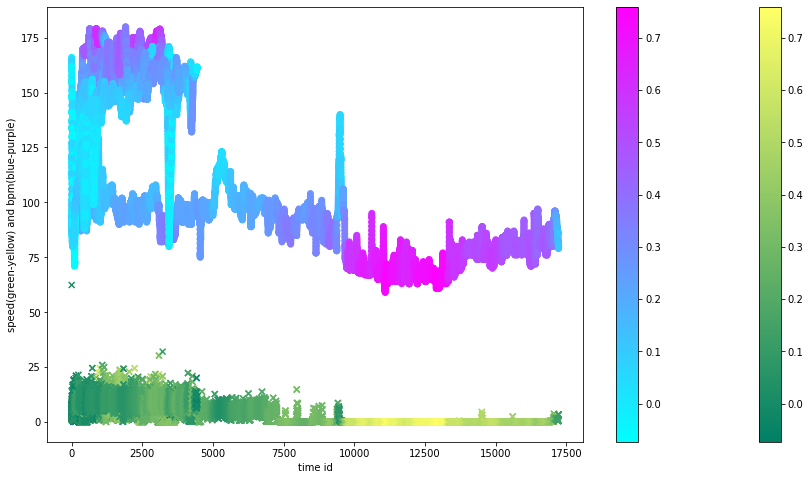

In [72]:
plt.scatter( test_data_cut['id'],test_data_cut['speed'], marker="x", c=scores_pointwise,cmap='summer' )
plt.colorbar();
plt.scatter( test_data_cut['id'],test_data_cut['bpm'],marker="o", c=scores_pointwise,cmap='cool' )
plt.colorbar();
plt.xlabel('time id')
plt.ylabel('speed(green-yellow) and bpm(blue-purple)')


#Final plots

In [2]:
test_runs = []

for i in range(1, len(start_index)):
  test_runs.append(test_with_scores[start_index[i-1]:start_index[i]])
test_runs.append(test_with_scores[start_index[-1]:])
test_runs[0].head(5)

NameError: ignored

In [1]:
# Pointwise methods
methods = ['knn', 'ocsvm', 'kde','gan']

for method in methods:
  method = 'gan'
  print()
  print(method)
  
  if method == 'gan':
    data = test_data_cut
    scores = test_data_cut
    runs = test_runs_cut
  else:
    data = test_data
    scores = test_with_scores
    runs = test_runs

  outlier_index = anomaly_classify(scores[method],thresholds[method], data, plot= True)
  plot_anomaly_score_bar(scores[method], data, with_limits = False, title = method)
  plot_score_distr(scores[method], thresholds[method], title= method)
  plot_test_runs(method, runs, scores, run=0)
  # break
  


gan


NameError: ignored